In [1]:
%load_ext autoreload
import os
import sys

In [3]:
os.environ['TRANSFORMERS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ['HF_DATASETS_CACHE'] = '/mnt/swordfish-pool2/milad/hf-cache-new'
os.environ["OPENAI_API_KEY"]= 'xxx'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
sys.path.append('./src-py')

In [4]:
import json
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import re
from collections import Counter

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


%autoreload
import utils
import prompts
import random

from tabulate import tabulate
import tiktoken
from llm_based_evaluation import *

/mnt/swordfish-pool2/milad/conda-envs/datadreamer/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [5]:
from transformers import AutoTokenizer, pipeline

In [6]:
import json
keys = json.load(open('./keys.json'))
for key, val in keys.items():
    os.environ[key] = val

In [7]:
from huggingface_hub import login

login(os.environ['hf_token'])

In [8]:
output_dir = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/'
models_folder = "/mnt/swordfish-pool2/milad/communicating-science-to-the-public/models/"

In [9]:
gpt_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B")

In [87]:
ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500'

### Evaluate Science Models

- Now we will evalaute the following models on a sample from the test set using only the generic prompt
    - LLAMA-3 baseline
    - Qwen baseline
    - LLAMA-3 fine-tuned on DeepSeek generated conversations
    - Qwen  fine-tuned on DeepSeek generated conversations

### Evaluation

#### Basic Evaluation

In [88]:
# generated_convs = {
#     #'gpt3-baseline' : datasets.load_from_disk(ds_path + '/gpt3-test-conv-ds'),
#     #'llama3-baseline' : datasets.load_from_disk(ds_path + '/baseline-llama3-test-conv-ds'),
#     'llama3-baseline-adv-prompt':datasets.load_from_disk(ds_path + '/baseline-advanced-prompt-llama3-test-conv-ds/'),
#     #'ft-40k-llama3-on-deepseek' :datasets.load_from_disk(ds_path + '/ft-40k-llama3-test-conv-ds'),
#     'ft-llama3-on-deepseek' :datasets.load_from_disk(ds_path + '/ft-llama3-test-conv-ds'),
#     'qwen-baseline-adv-prompt':datasets.load_from_disk(ds_path + '/baseline-qwen-test-conv-ds'),
#     #'ft-qwen-on-deepseek' :datasets.load_from_disk(ds_path + '/ft-40k-qwen-test-conv-ds/'),
#     'ft-qwen-on-deepseek' :datasets.load_from_disk(ds_path + '/ft-qwen-full-ds-training-test-conv-ds'),
# }

generated_convs = {
    #'llama3-baseline':datasets.load_from_disk(ds_path + '/baseline-advanced-prompt-llama3-test-conv-ds/'),
    'qwen-baseline':datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv'),
    'ft-qwen-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv'),
    'llama-baseline':datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv'),
    'ft-llama-on-deepseek' :datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv'),
}

In [37]:
# generated_convs['qwen-baseline'] = generated_convs['qwen-baseline'].map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})
# generated_convs['ft-qwen-on-deepseek'] = generated_convs['ft-qwen-on-deepseek'].map(lambda row: {'pr-article': paper_id_to_article[row['paper_id']]})

In [89]:
def evalaute_convs(datasets):
    eval_results = {}
    for name, ds in datasets.items():
        eval_results[name] = utils.evaluate_conv(ds['conversation'], None, ds['pr-article'])

    print(tabulate(
        [[name] + list(eval_res.values())[:3] for name, eval_res in eval_results.items()],
        headers=['Prompt', 'Rouge-1', 'Rouge-L', 'BERT-f1']
    ))

In [91]:
print('Results on 500 sample')
all_synth_conversations = evalaute_convs(generated_convs)

Results on 500 sample
Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.3        0.127      0.825
ft-qwen-on-deepseek       0.345      0.135      0.827
llama-baseline            0.333      0.144      0.821
ft-llama-on-deepseek      0.43       0.168      0.834


In [53]:
all_synth_conversations = evalaute_convs(generated_convs)

Prompt                  Rouge-1    Rouge-L    BERT-f1
--------------------  ---------  ---------  ---------
qwen-baseline             0.304      0.128      0.822
ft-qwen-on-deepseek       0.353      0.136      0.824
llama-baseline            0.346      0.147      0.819
ft-llama-on-deepseek      0.435      0.167      0.832


#### LLM-based Evaluation

In [92]:
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [94]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500/baseline_qwen_gen_conv from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500/ft_qwen_gen_conv/ from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500/baseline_llama3_gen_conv from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500/ft_llama3_gen_conv/ from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.16                      2.37                    1.83   2.79
ft-qwen-on-deepseek                    3.99                      2.35                    1.89   2.74
llama-baseline                         4.17       

In [20]:
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].map(lambda row: {'conversation': '\n\n'.join(['{}: {}'.format('Journalist', x['content']) if x['role'] == 'assistant' else '{}: {}'.format('Researcher', x['content']) for x in row['generated_conversation'][1:]])})
# generated_convs['llama3-baseline'][0] = generated_convs['llama3-baseline'][0].map(lambda row: {'conversation': '\n\n'.join(['{}: {}'.format('Journalist', x['content']) if x['role'] == 'assistant' else '{}: {}'.format('Researcher', x['content']) for x in row['generated_conversation'][1:]])})
# generated_convs['gpt3-baseline'][0] = generated_convs['gpt3-baseline'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])
# generated_convs['llama3-baseline'][0] = generated_convs['llama3-baseline'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].remove_columns(['societal_eval_prompt_scoring_parsed', 'scientific_eval_prompt_scoring_parsed', 'clarity_eval_prompt_scoring_parsed'])

In [55]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_100/baseline_qwen_gen_conv from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_100/ft_qwen_gen_conv/ from already saved file


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [08:29<00:00,  5.10s/it]


Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [07:57<00:00,  4.78s/it]


Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.06                      2.42                    1.82   2.77
ft-qwen-on-deepseek                    3.98                      2.29                    1.85   2.71
llama-baseline                         4.13                      2.18                    1.63   2.65
ft-llama-on-deepseek                   4.33                      2.19                    1.88   2.8


-------

#### Evaluating the ground-truth generated convs:

In [13]:
gt_convs = {'original_deepseek_conv': [datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample'), '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample']}

In [14]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_gt_results = llm_based_evaluation(prompts_to_eval, gt_convs, force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/processed_test_ds_sample from already saved file
#                         clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
----------------------  ---------------------  ------------------------  ----------------------  -----
original_deepseek_conv                   4.52                       2.2                    2.06   2.93


------

### Analysis of the automatic evalaution

In [61]:
# To add the topic to the data
deepseek_conv_dataset = datasets.load_from_disk('/mnt/swordfish-pool2/milad/communicating-science-to-the-public/deepseek-final-conv-ds-cleaned/')
paper_id_to_article = {x['id']: x['pr-article'] for x in deepseek_conv_dataset}
paper_id_to_topic = {x['id']: x['Topic'] for x in deepseek_conv_dataset}

In [95]:
ds_path = '/mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500/'
generated_convs = {
    'qwen-baseline':[datasets.load_from_disk(ds_path + '/baseline_qwen_gen_conv/'), ds_path + '/baseline_qwen_gen_conv'],
    'ft-qwen-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_qwen_gen_conv/'),ds_path +  '/ft_qwen_gen_conv/'],
    'llama-baseline':[datasets.load_from_disk(ds_path + '/baseline_llama3_gen_conv/'), ds_path + '/baseline_llama3_gen_conv'],
    'ft-llama-on-deepseek' :[datasets.load_from_disk(ds_path + '/ft_llama3_gen_conv/'),ds_path +  '/ft_llama3_gen_conv/'],
}

In [57]:
# generated_convs['llama3-baseline-adv-prompt'][0] = generated_convs['llama3-baseline-adv-prompt'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['qwen-baseline-adv-prompt'][0] = generated_convs['qwen-baseline-adv-prompt'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['ft-llama3-on-deepseek'][0] = generated_convs['ft-llama3-on-deepseek'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})
# generated_convs['ft-qwen-on-deepseek'][0] = generated_convs['ft-qwen-on-deepseek'][0].map(lambda row: {'topic': paper_id_to_topic[row['paper_id']]})

In [96]:
prompts_to_eval = [prompts.clarity_eval_prompt, prompts.scientific_context_eval_prompt, prompts.societal_context_eval_prompt]

llm_eval_results = llm_based_evaluation(prompts_to_eval, generated_convs, force_generation=False)

Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_qwen_gen_conv from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_qwen_gen_conv/ from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//baseline_llama3_gen_conv from already saved file
Loading /mnt/swordfish-pool2/milad/communicating-science-to-the-public/eval_experiment_500//ft_llama3_gen_conv/ from already saved file
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.16                      2.37                    1.83   2.79
ft-qwen-on-deepseek                    3.99                      2.35                    1.89   2.74
llama-baseline                         4.17   

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def histogram_of_scores(llm_eval_scores, scoring_scheme, chart_title):
    llm_eval_scores = {x[0]: [s['score'] for s in x[1][scoring_scheme]] for x in llm_eval_results.items()}
    # Assuming llm_eval_scores is a dict {model_name: list of scores}
    bin_edges = np.histogram_bin_edges(np.concatenate(list(llm_eval_scores.values())), bins='auto')
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = (bin_edges[1] - bin_edges[0])
    num_models = len(llm_eval_scores)
    bar_width = bin_width / num_models
    
    for i, (key, val) in enumerate(llm_eval_scores.items()):
        counts, _ = np.histogram(val, bins=bin_edges)
        offset = (i - num_models / 2) * bar_width + bar_width / 2
        plt.bar(bin_centers + offset, counts, width=bar_width, alpha=0.8, label=key)
    
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.title(chart_title)
    plt.legend()
    plt.tight_layout()
    plt.show()

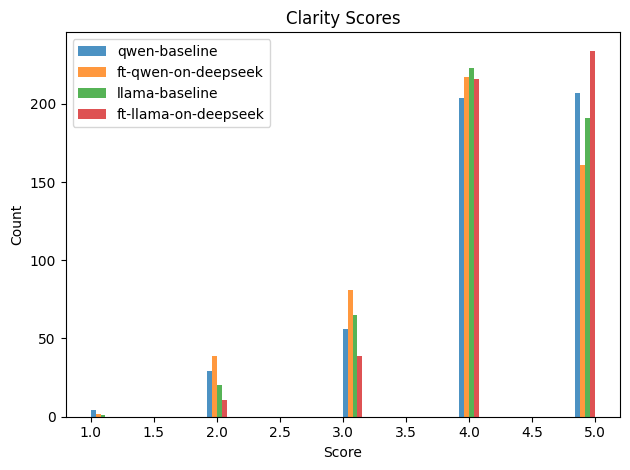

In [98]:
histogram_of_scores(llm_eval_results, 'clarity_eval_prompt_scoring_parsed', 'Clarity Scores')

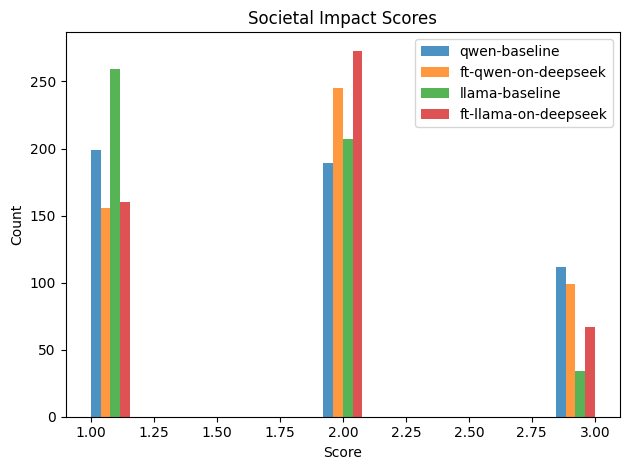

In [99]:
histogram_of_scores(llm_eval_results, 'societal_eval_prompt_scoring_parsed', 'Societal Impact Scores')

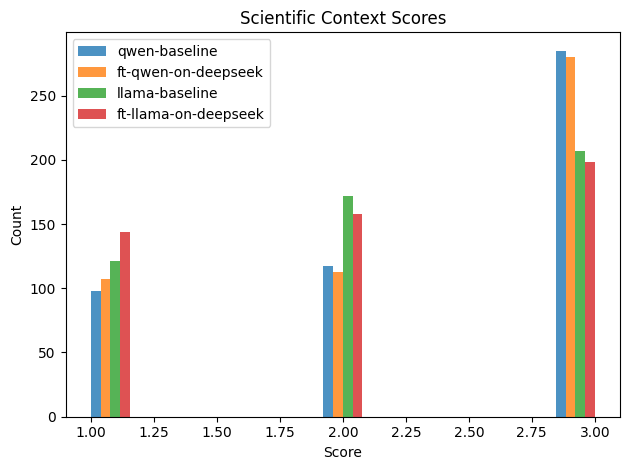

In [100]:
histogram_of_scores(llm_eval_results, 'scientific_eval_prompt_scoring_parsed', 'Scientific Context Scores')

### Per topic analysis

In [107]:
for topic in set(paper_id_to_topic.values()):
    topic_ds = llm_eval_results['qwen-baseline'].filter(lambda row: row['topic'] ==topic)
    print(topic, '#inst: ', len(topic_ds))
    print(tabulate(
        [[name] + get_llm_avg_scores(res.filter(lambda row: row['topic'] ==topic), prompts_to_eval) for name, res in llm_eval_results.items()],
        headers=['#'] + [p['strategy_name'] for p in prompts_to_eval] + ['Avg']
    ))
    print()
    print('===============')

Medicine #inst:  198
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          4.23                      2.34                    1.92   2.83
ft-qwen-on-deepseek                    3.88                      2.35                    1.82   2.68
llama-baseline                         4.26                      2.19                    1.6    2.68
ft-llama-on-deepseek                   4.37                      2.08                    1.75   2.73

Chemistry #inst:  44
#                       clarity_eval_prompt    scientific_eval_prompt    societal_eval_prompt    Avg
--------------------  ---------------------  ------------------------  ----------------------  -----
qwen-baseline                          3.98                      2.43                    1.55   2.65
ft-qwen-on-deepseek                    4.16     